<a href="https://colab.research.google.com/github/ai-art-dev99/brain-tumor-classification-hybrid-approach/blob/main/brain_tumor_classification_hybrid_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import os
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from tqdm.notebook import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import concurrent
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed
from sys import platform as _platform
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

In [ ]:
train_dir = '/content/drive/MyDrive/CVDataset/Training'
test_dir = '/content/drive/MyDrive/CVDataset/Testing'

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import os
import cv2

# List of image filenames to read
image_files = ['Tr-glTr_0000.jpg']

# Loop through the selected image files and read them
for image_file in image_files:
    image_path = os.path.join(f'{train_dir}/glioma', image_file)
    image = cv2.imread(image_path)
    print(image.shape)

    # Process the image as needed
    print(f'Loaded image: {image_file}')
    # Your image processing code here

(512, 512, 3)
Loaded image: Tr-glTr_0000.jpg


# Helper Functions

{'notumor': 1000, 'pituitary': 1000, 'meningioma': 1000, 'glioma': 1000}


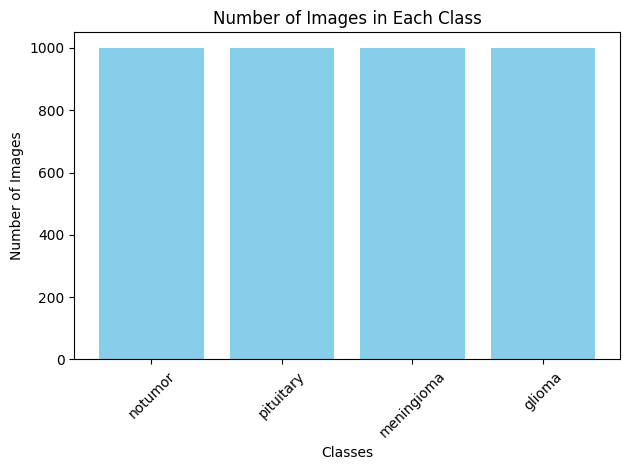

In [ ]:
import os
import matplotlib.pyplot as plt

def count_images_in_classes(dataset_path):
    class_counts = {}

    for class_name in os.listdir(dataset_path):
        class_dir = os.path.join(dataset_path, class_name)

        if os.path.isdir(class_dir):
            image_count = len([file for file in os.listdir(class_dir) if file.endswith(('.png', '.jpg', '.jpeg'))])
            class_counts[class_name] = image_count

    return class_counts

def plot_image_counts(class_counts):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Number of Images in Each Class')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

dataset_path = '/content/drive/MyDrive/CVDataset/Training'
testset_path = '/content/drive/MyDrive/CVDataset/Testing'
image_counts = count_images_in_classes(testset_path)
print(image_counts)

plot_image_counts(image_counts)

## Scalability

In this part we have increased the amount of test images in the dataset:
<table>
<caption><strong>number of test images for each round</strong></caption>
<th>round</th>
<th>notumor</th>
<th>pituitary</th>
<th>meningioma</th>
<th>glioma</th>
<th>total images</th>
<th>accuracy</th>
<th>time</th>
<tr><td>1</td><td>405</td><td>300</td><td>306</td><td>300</td><td>1311</td><td>KNN: 0.9643259481787457<br/>
SVC:  0.9797221179121292<br/>
RF:  0.9369132557266241<br/>
MLP:  0.9665790461885092</td><td>KNN:<br/>
Execution time (training process...) : 24.32112717628479
, Execution time (training and prediction process...) : 32.66558384895325<br/>
SVC:<br/>
Execution time (training process...) : 397.1736493110657
, Execution time (training and prediction process...) : 517.7053318023682<br/>
RF:<br/>
Execution time (training process...) : 240.96821546554565
, Execution time (training and prediction process...) : 243.82635879516602<br/>
MLP:<br/>
Execution time (training process...) : 2049.7487528324127
, Execution time (training and prediction process...) : 2052.322859764099</td></tr>
<tr><td>2</td><td>800</td><td>800</td><td>800</td><td>800</td><td>3200</td><td>KNN:  0.9503125<br/>
SVC:  0.973125<br/>
RF:  0.9203125<br/>
MLP:  0.9553125</td><td>KNN:<br/>Execution time (training process...) : 29.53621482849121
, Execution time (training and prediction process...) : 40.936408281326294<br/>
SVC:<br/>Execution time (training process...) : 480.3835813999176
, Execution time (training and prediction process...) : 645.2583339214325<br/>
RF:<br/>Execution time (training process...) : 240.1299660205841
, Execution time (training and prediction process...) : 243.61064958572388<br/>
MLP:<br/>Execution time (training process...) : 2043.6284203529358
, Execution time (training and prediction process...) : 2046.8812081813812</td></tr>
<tr><td>3</td><td>1000</td><td>1000</td><td>1000</td><td>1000</td><td>4000</td><td>KNN:  0.94475<br/>
SVC:  0.96225<br/>
RF:  0.9145<br/>
MLP:  0.94375</td><td>KNN:<br/>Execution time (training process...) : 27.394189834594727
, Execution time (training and prediction process...) : 41.58968114852905<br/>
SVC:<br/>Execution time (training process...) : 503.4015369415283
, Execution time (training and prediction process...) : 699.6503903865814<br/>
RF:<br/>Execution time (training process...) : 239.97216606140137
, Execution time (training and prediction process...) : 243.98494958877563<br/>
MLP:<br/>Execution time (training process...) : 2589.792064189911
, Execution time (training and prediction process...) : 2593.601837873459</td></tr>
<tr><td>4</td><td>1500</td><td>1500</td><td>1500</td><td>1500</td><td>6000</td><td>KNN:  0.9326666666666666<br/>
SVC:  0.958<br/>
RF:  0.9093333333333333<br/>
MLP:  0.939</td><td>KNN:<br/>Execution time (training process...) : 29.31498956680298
, Execution time (training and prediction process...) : 51.31178522109985<br/>
SVC:<br/>Execution time (training process...) : 468.77425503730774
, Execution time (training and prediction process...) : 759.8883831501007<br/>
RF:<br/>Execution time (training process...) : 238.86373162269592
, Execution time (training and prediction process...) : 245.75106143951416<br/>
MLP:<br/>Execution time (training process...) : 2160.0736377239227
Execution time (training and prediction process...) : 2166.2905004024506</td></tr>
</table>

## Image Augmentation

In [ ]:
!pip install imgaug pillow

In [ ]:
import random
import imgaug.augmenters as iaa

def augment_images(class_dir, target_count):
    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]
    current_count = len(images)

    seq = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Affine(rotate=(-25, 25)),
        iaa.AdditiveGaussianNoise(scale=(10, 30)),
        iaa.Multiply((0.8, 1.2)),
    ])

    while current_count < target_count:
        img_path = random.choice(images)
        img = Image.open(img_path)
        img = img.convert('RGB')
        img = seq(image=np.array(img))
        augmented_img = Image.fromarray(img)

        augmented_img.save(os.path.join(class_dir, f'augmented_{current_count}.jpg'))
        current_count += 1

class_dirs = ['/content/drive/MyDrive/CVDataset/Testing/glioma',
              '/content/drive/MyDrive/CVDataset/Testing/meningioma',
              '/content/drive/MyDrive/CVDataset/Testing/notumor',
              '/content/drive/MyDrive/CVDataset/Testing/pituitary']
target_count = 1500

for class_dir in class_dirs:
    augment_images(class_dir, target_count)

Number of Images in dataset after <strong>Data Augmentation</strong>

{'notumor': 1500, 'pituitary': 1500, 'meningioma': 1500, 'glioma': 1500}


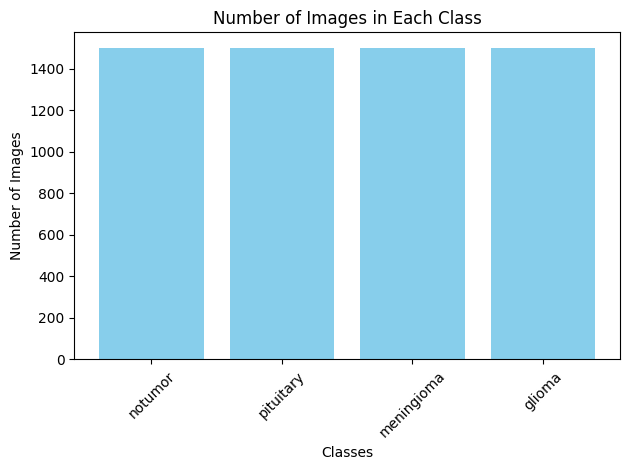

In [ ]:
dataset_path = '/content/drive/MyDrive/CVDataset/Testing'
image_counts = count_images_in_classes(dataset_path)
print(image_counts)

plot_image_counts(image_counts)

## Process and  Show

In [ ]:
def preprocessing(config):
  batch_size = config['batch_size']
  data_transforms = transforms.Compose(config['transforms'])

  train_dataset = ImageFolder(train_dir, transform=data_transforms)
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  val_dataset = ImageFolder(test_dir, transform=data_transforms)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

  return (train_dataset, train_loader), (val_dataset, val_loader)

In [ ]:
def show_images(train_data):
  train_dataset, train_loader = train_data
  data_iter = iter(train_loader)
  images, labels = next(data_iter)

  images = (images.numpy().transpose((0, 2, 3, 1))).clip(0, 1)

  num_images = len(images)
  rows = int(np.ceil(num_images / 4))
  fig, axes = plt.subplots(rows, 4, figsize=(15, 15))

  for i, ax in enumerate(axes.flat):
      if i < num_images:
          ax.imshow(images[i])
          ax.set_title(f'Label: {train_dataset.classes[labels[i]]} | {labels[i]}')
      ax.axis('off')

  plt.tight_layout()
  plt.show()

# Preprocessing

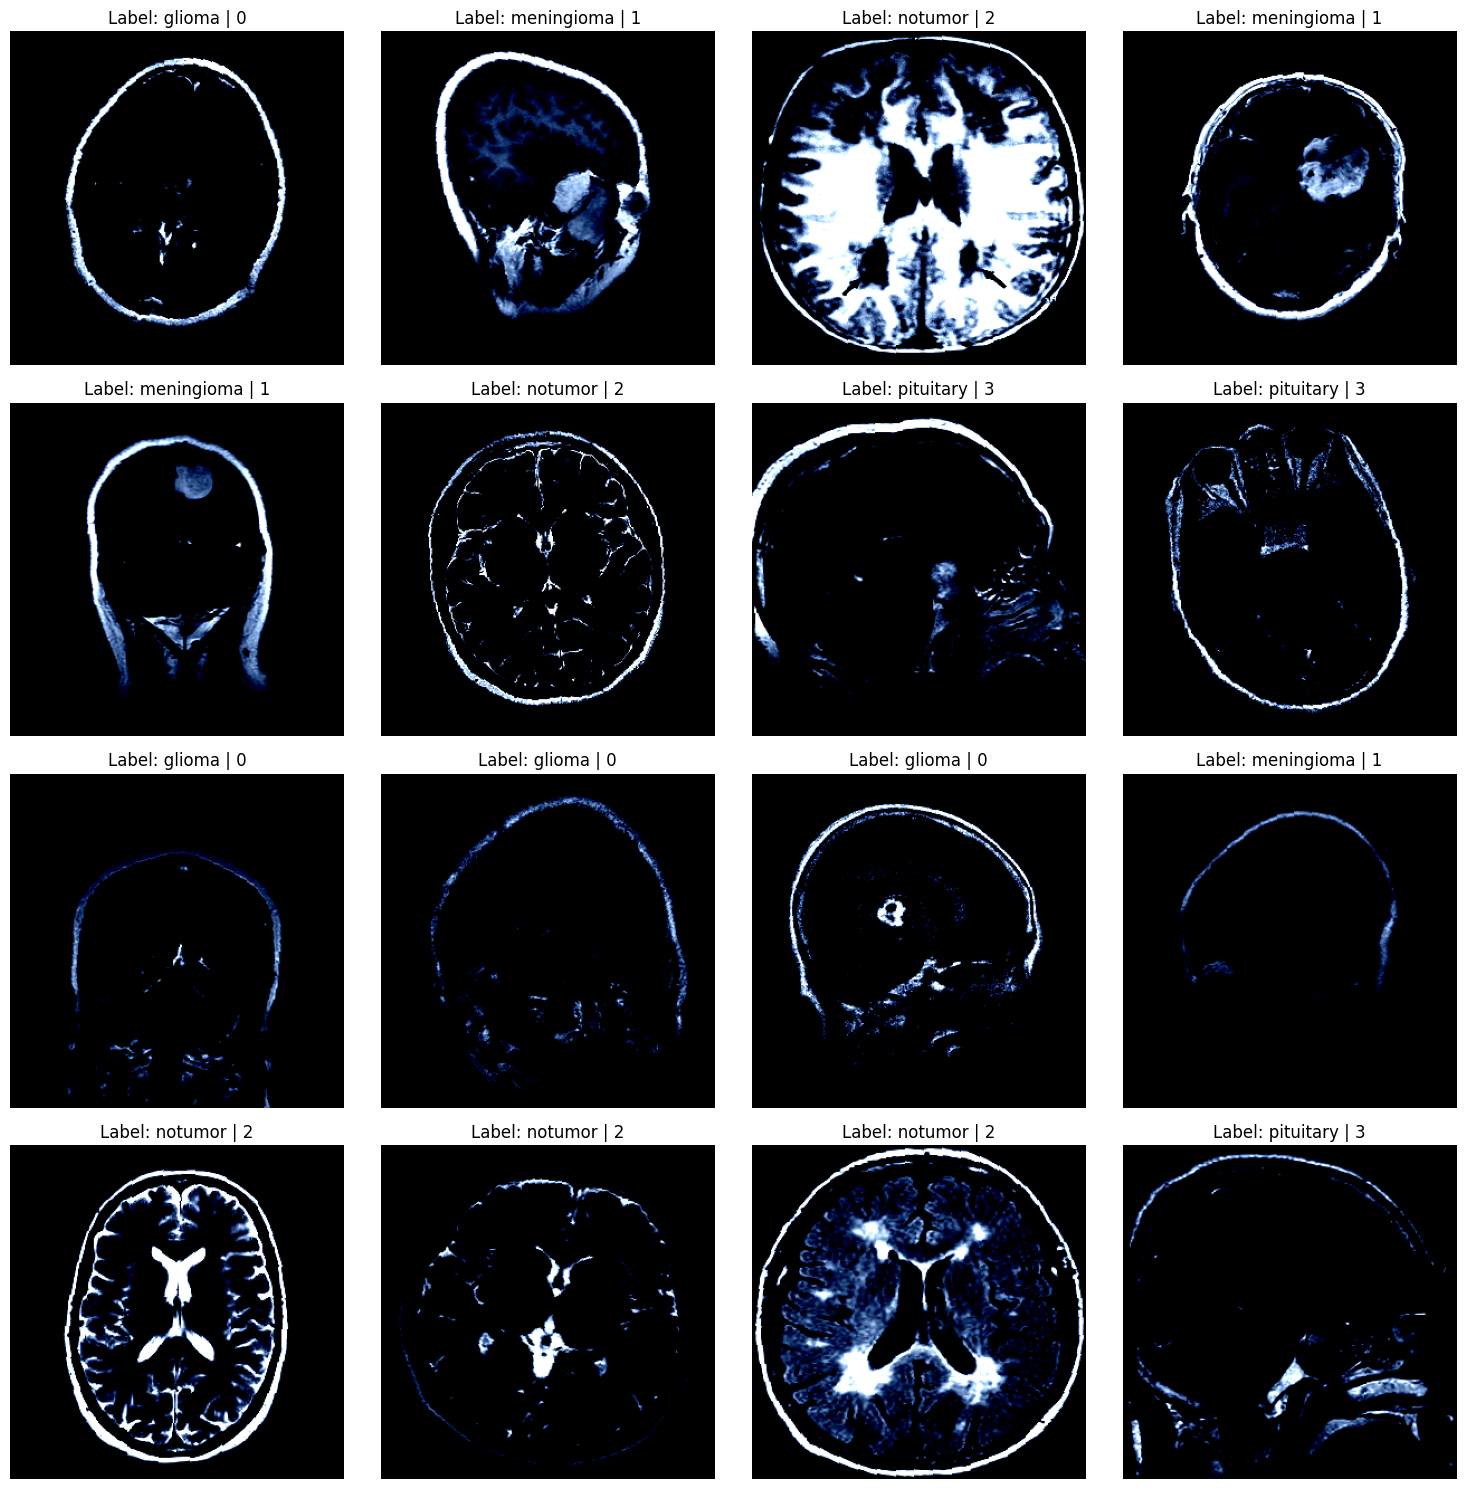

In [ ]:
image_size = (299, 299)
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
brightness = (0.8, 1.2)
contrast = (0.8, 1.2)
rotate = 10

config = {
    'transforms': [transforms.Resize(image_size), transforms.ColorJitter(brightness=brightness, contrast=contrast),
                   transforms.RandomHorizontalFlip(), transforms.RandomRotation(rotate),
                   transforms.ToTensor(), transforms.Normalize(*imagenet_stats)],
    'batch_size': 16
}

train_data, val_data = preprocessing(config)
show_images(train_data)

# Modeling

After saving the model just for loading we can use this code snippet

In [ ]:
efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)

for layer in efficientnet.parameters():
  layer.requires_grad = False

efficientnet = nn.Sequential(*(list(efficientnet.children())[:-1]))

efficientnet.to(device)

In [ ]:
efficientnet.load_state_dict(torch.load('/content/best_model.pth'))

<All keys matched successfully>

## Deep Model (EfficientNet)
For training the model and update its weights, here we have to save efficinet's new weights and also the deep model

In [ ]:
efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)

in_features = efficientnet.classifier.fc.in_features

for layer in efficientnet.parameters():
  layer.requires_grad = True

efficientnet = nn.Sequential(*(list(efficientnet.children())[:-1]))

effnet = nn.Sequential(
    efficientnet,
    nn.Flatten(),
    nn.Dropout(p=0.3),
    nn.Linear(in_features * 100, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.25),
    nn.Linear(128, 4)
)

effnet.to(device)

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
Downloading: "https://api.ngc.nvidia.com/v2/models/nvidia/efficientnet_b0_pyt_amp/versions/20.12.0/files/nvidia_efficientnet-b0_210412.pth" to /root/.cache/torch/hub/checkpoints/nvidia_efficientnet-b0_210412.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 105MB/s]


Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (activation): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): Sequential(
        (block0): MBConvBlock(
          (depsep): Sequential(
            (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
            (act): SiLU(inplace=True)
          )
          (se): SequentialSqueezeAndExcitation(
            (squeeze): Linear(in_features=32, out_features=8, bias=True)
            (expand): Linear(in_features=8, out_features=32, bias=True)
            (activation): SiLU(inplace=True)
            (sigmoid): Sigmoid()
            (mul_a_quantizer): Identity()
         

In [ ]:
def training_loop(best_val_accuracy,
                  train_losses, train_accuracies,
                  val_losses, val_accuracies):

  train_dataset, train_loader = train_data
  val_dataset, val_loader = val_data

  num_epochs = 10

  optimizer = optim.Adam(effnet.parameters(), lr=0.001)
  criterion = nn.CrossEntropyLoss()

  for epoch in tqdm_notebook(range(num_epochs)):
      effnet.train()
      train_loss = 0.0
      correct = 0
      total = 0

      for batch_idx, (inputs, labels) in tqdm_notebook(enumerate(train_loader), total=len(train_loader),
                                                      desc='Training...'):
          inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad()
          outputs = effnet(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          train_loss += loss.item()
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      train_accuracy = correct / total
      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy)


      effnet.eval()
      val_loss = 0.0
      correct = 0
      total = 0

      with torch.no_grad():
          for inputs, labels in tqdm_notebook(val_loader, total=len(val_loader), desc='Validating...'):
              inputs, labels = inputs.to(device), labels.to(device)
              outputs = effnet(inputs)
              loss = criterion(outputs, labels)

              val_loss += loss.item()
              _, predicted = torch.max(outputs, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

      val_loss /= len(val_loader)
      val_accuracy = correct / total
      val_losses.append(val_loss)
      val_accuracies.append(val_accuracy)

      print(f'Epoch [{epoch+1}/{num_epochs}], '
            f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2%}, '
            f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2%}')


      # Save the best model
      if val_accuracy > best_val_accuracy:
          best_val_accuracy = val_accuracy
          torch.save(efficientnet.state_dict(), f'best_efficient_{epoch}.pth')
          torch.save(effnet.state_dict(), f'best_effnet_{epoch}.pth')

In [ ]:
best_val_accuracy = 0.0
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

pool = ProcessPoolExecutor if _platform.startswith('linux') else ThreadPoolExecutor
with pool(max_workers=4) as ex:
    training_loop(best_val_accuracy,
                  train_losses,
                  train_accuracies,
                  val_losses,
                  val_accuracies)

  0%|          | 0/10 [00:00<?, ?it/s]

Training...:   0%|          | 0/750 [00:00<?, ?it/s]

Validating...:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch [1/10], Training Loss: 312.5898, Training Accuracy: 87.19%, Validation Loss: 0.3383, Validation Accuracy: 89.93%


Training...:   0%|          | 0/750 [00:00<?, ?it/s]

Validating...:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch [2/10], Training Loss: 180.4875, Training Accuracy: 92.45%, Validation Loss: 0.1685, Validation Accuracy: 93.14%


Training...:   0%|          | 0/750 [00:00<?, ?it/s]

Validating...:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch [3/10], Training Loss: 143.5241, Training Accuracy: 94.25%, Validation Loss: 0.6238, Validation Accuracy: 82.53%


Training...:   0%|          | 0/750 [00:00<?, ?it/s]

Validating...:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch [4/10], Training Loss: 147.4611, Training Accuracy: 94.56%, Validation Loss: 0.0804, Validation Accuracy: 97.25%


Training...:   0%|          | 0/750 [00:00<?, ?it/s]

Validating...:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch [5/10], Training Loss: 105.5027, Training Accuracy: 95.96%, Validation Loss: 0.2045, Validation Accuracy: 94.89%


Training...:   0%|          | 0/750 [00:00<?, ?it/s]

Validating...:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch [6/10], Training Loss: 108.4005, Training Accuracy: 96.01%, Validation Loss: 0.4314, Validation Accuracy: 94.81%


Training...:   0%|          | 0/750 [00:00<?, ?it/s]

Validating...:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch [7/10], Training Loss: 111.1561, Training Accuracy: 95.62%, Validation Loss: 0.3154, Validation Accuracy: 92.60%


Training...:   0%|          | 0/750 [00:00<?, ?it/s]

Validating...:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch [8/10], Training Loss: 92.1558, Training Accuracy: 96.61%, Validation Loss: 0.4350, Validation Accuracy: 92.75%


Training...:   0%|          | 0/750 [00:00<?, ?it/s]

Validating...:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch [9/10], Training Loss: 87.0994, Training Accuracy: 96.73%, Validation Loss: 0.0656, Validation Accuracy: 97.71%


Training...:   0%|          | 0/750 [00:00<?, ?it/s]

Validating...:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch [10/10], Training Loss: 98.4092, Training Accuracy: 96.43%, Validation Loss: 0.0616, Validation Accuracy: 97.56%


Loss and Accuracy Trend

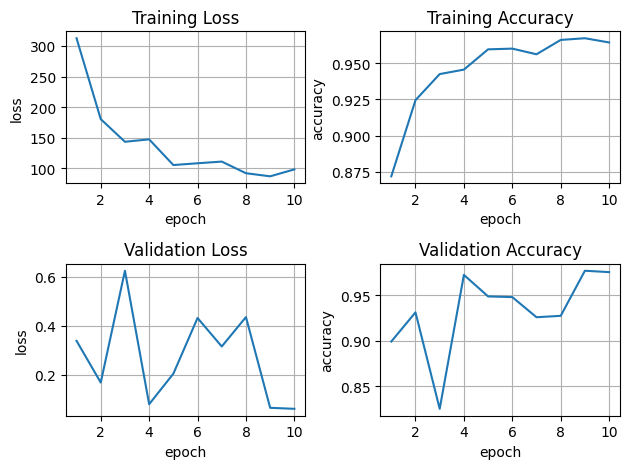

In [ ]:
epochs_x = [i+1 for i in range(10)]

fig, axs = plt.subplots(2, 2)

axs[0, 0].grid(True)
axs[0, 0].set_title('Training Loss')
axs[0, 0].set_xlabel('epoch')
axs[0, 0].set_ylabel('loss')
axs[0, 0].plot(epochs_x, train_losses)

axs[0, 1].grid(True)
axs[0, 1].set_title('Training Accuracy')
axs[0, 1].set_xlabel('epoch')
axs[0, 1].set_ylabel('accuracy')
axs[0, 1].plot(epochs_x, train_accuracies)

axs[1, 0].grid(True)
axs[1, 0].set_title('Validation Loss')
axs[1, 0].set_xlabel('epoch')
axs[1, 0].set_ylabel('loss')
axs[1, 0].plot(epochs_x, val_losses)

axs[1, 1].grid(True)
axs[1, 1].set_title('Validation Accuracy')
axs[1, 1].set_xlabel('epoch')
axs[1, 1].set_ylabel('accuracy')
axs[1, 1].plot(epochs_x, val_accuracies)

fig.tight_layout()

<ol>
<li>Specificity</li>
<li>Sensitivity</li>
<li>f1 score</li>
<li>accuracy</li>
<li>confustion matrix</li>
</ol>

In [ ]:
effnet.load_state_dict(torch.load('/content/best_effnet_8.pth'))

<All keys matched successfully>

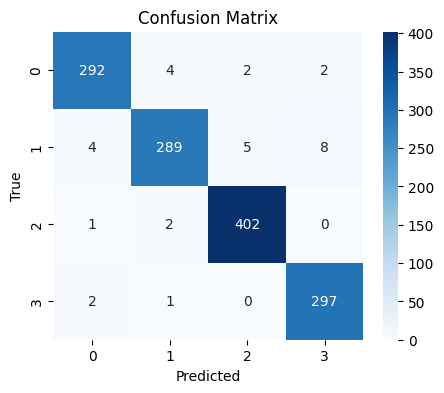

In [ ]:
from sklearn.metrics import confusion_matrix

effnet.eval()

effnet_y_true = []
effnet_y_pred = []

with torch.no_grad():
    for images, labels in val_loader:
        outputs = effnet(images)
        _, predicted = torch.max(outputs, 1)

        effnet_y_true.extend(labels.numpy())
        effnet_y_pred.extend(predicted.numpy())

effnet_cm = confusion_matrix(effnet_y_true, effnet_y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(effnet_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(effnet_y_true), yticklabels=np.unique(effnet_y_true))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
evaluation(effnet_cm)

Class 0: Sensitivity = 0.97, Specificity = 0.99, Accuracy = 0.95
Class 1: Sensitivity = 0.94, Specificity = 0.99, Accuracy = 0.92
Class 2: Sensitivity = 0.99, Specificity = 0.99, Accuracy = 0.98
Class 3: Sensitivity = 0.99, Specificity = 0.99, Accuracy = 0.96

Average Sensitivity: 0.98
Average Specificity: 0.99
Average Accuracy: 0.95


# Hybrid Model

Now we should load the best model and create a new model which is feature extractor

In [ ]:
efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
efficientnet = nn.Sequential(*(list(efficientnet.children())[:-1]))

efficientnet.to(device)

In [ ]:
efficientnet.load_state_dict(torch.load('/content/best_efficient_8.pth'))

<All keys matched successfully>

In [ ]:
for layer in efficientnet.parameters():
  layer.requires_grad = False

feature_extractor = nn.Sequential(
    efficientnet,
    nn.Flatten()
)

feature_extractor.to(device)

Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (activation): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): Sequential(
        (block0): MBConvBlock(
          (depsep): Sequential(
            (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
            (act): SiLU(inplace=True)
          )
          (se): SequentialSqueezeAndExcitation(
            (squeeze): Linear(in_features=32, out_features=8, bias=True)
            (expand): Linear(in_features=8, out_features=32, bias=True)
            (activation): SiLU(inplace=True)
            (sigmoid): Sigmoid()
            (mul_a_quantizer): Identity()
         

In [ ]:
train_dataset, train_loader = train_data
val_dataset, val_loader = val_data

Now we extract feature maps from MRI images

In [ ]:
def train_loop(model, train, test):
  final_outputs_train = []
  final_outputs_test = []

  model.train()

  for index, (inputs, labels) in tqdm_notebook(enumerate(train), total=len(train), desc="Processing on Train..."):
    inputs = inputs.reshape((1, *inputs.shape))
    inputs = inputs.to(device)

    outputs = model(inputs)
    final_outputs_train.append(outputs)

  for index, (inputs, labels) in tqdm_notebook(enumerate(test), total=len(test), desc="Processing on Test..."):
    inputs = inputs.reshape((1, *inputs.shape))
    inputs = inputs.to(device)

    outputs = model(inputs)
    final_outputs_test.append(outputs)


  return final_outputs_train, final_outputs_test

with parallel processing, speed up the process of extracting features

In [ ]:
def parallel_train(workers):
    pool = ProcessPoolExecutor if _platform.startswith('linux') else ThreadPoolExecutor
    with pool(max_workers=workers) as ex:
        final_outputs_train, final_outputs_test = train_loop(efficientnet, train_dataset, val_dataset)
    return final_outputs_train, final_outputs_test

In [ ]:
features_result = parallel_train(workers=4)

Processing on Train...:   0%|          | 0/12000 [00:00<?, ?it/s]

Processing on Test...:   0%|          | 0/6000 [00:00<?, ?it/s]

In [ ]:
X_train = [output.cpu()
                 .data.numpy()
                 .reshape(-1, output.shape[-1])
                 .flatten()
                 for output in tqdm_notebook(features_result[0])]

X_test =  [output.cpu()
                 .data.numpy()
                 .reshape(-1, output.shape[-1])
                 .flatten()
                 for output in tqdm_notebook(features_result[1])]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

In [ ]:
def parallel_label(workers):
  pool = ProcessPoolExecutor if _platform.startswith('linux') else ThreadPoolExecutor
  with pool(max_workers=workers) as ex:
      train_labels = [labels for index, (inputs, labels) in tqdm_notebook(enumerate(train_dataset), total=len(train_dataset))]
      test_labels  = [labels for index, (inputs, labels) in tqdm_notebook(enumerate(val_dataset), total=len(val_dataset))]
  return train_labels, test_labels

y_train, y_test = parallel_label(4)
# y = np.concatenate((train_labels, test_labels))

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train_RF, y, test_size=0.2, random_state=24)

## Machine Learning Models

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

In [ ]:
def parallel_clf(model, workers):
  pool = ProcessPoolExecutor if _platform.startswith('linux') else ThreadPoolExecutor
  with pool(max_workers=4) as ex:
      clf = make_pipeline(StandardScaler(), model)
      clf.fit(X_train, y_train)
  return clf

In [ ]:
classifiers = {
    'knn': KNeighborsClassifier(3),
    'svc': SVC(kernel="linear", C=0.025, random_state=42),
    'rf': RandomForestClassifier(
        max_depth=5, n_estimators=100, random_state=42
    ),
    'mlp': MLPClassifier(alpha=1, max_iter=1000, random_state=42),
}

In [ ]:
import time
preds = {}
for (name, model) in tqdm_notebook(classifiers.items()):
  start_time = time.time()
  clf = parallel_clf(model, 4)
  print(f"Execution time (training process...) : {time.time() - start_time}")
  y_pred = clf.predict(X_test)
  print(f"Execution time (training and prediction process...) : {time.time() - start_time}")
  preds[name] = y_pred

  0%|          | 0/4 [00:00<?, ?it/s]

Execution time (training process...) : 29.31498956680298
Execution time (training and prediction process...) : 51.31178522109985
Execution time (training process...) : 468.77425503730774
Execution time (training and prediction process...) : 759.8883831501007
Execution time (training process...) : 238.86373162269592
Execution time (training and prediction process...) : 245.75106143951416
Execution time (training process...) : 2160.0736377239227
Execution time (training and prediction process...) : 2166.2905004024506


saving trained models

In [ ]:
import pickle

for (name, model) in classifiers.items():
  file_name = f'{name}_classifier.pkl'
  with open(file_name, 'wb') as file:
    pickle.dump(model, file)

In [ ]:
from google.colab import files
files.download('knn_classifier.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Evaluation

<ol>
<li>Specificity</li>
<li>Sensitivity</li>
<li>f1 score</li>
<li>accuracy</li>
<li>confustion matrix</li>
</ol>

load trained models

In [ ]:
import pickle

for (name, model) in classifiers.items():
  file_name = f'{name}_classifier.pkl'
  with open(file_name, 'rb') as file:
      classifiers[name] = pickle.load(file)

***Accuracy***

In [ ]:
for (name, y_pred) in preds.items():
  print(f"{name} | Accuracy: ", accuracy_score(y_test, y_pred))

knn | Accuracy:  0.9326666666666666
svc | Accuracy:  0.958
rf | Accuracy:  0.9093333333333333
mlp | Accuracy:  0.939


***Classification Report***

In [ ]:
!pip install openpyxl

In [ ]:
for (name, y_pred) in preds.items():
  report = classification_report(y_test, y_pred, output_dict=True)
  report_df = pd.DataFrame(report).transpose()
  report_df.to_excel(f'classification_report_{name}.xlsx')
  print(f"{name} | Report: ", classification_report(y_test, y_pred))
  print("_______________________________________________")

knn | Report:                precision    recall  f1-score   support

           0       0.94      0.98      0.96       683
           1       0.98      0.91      0.94       647
           2       0.99      0.97      0.98       676
           3       0.95      1.00      0.98       657

    accuracy                           0.96      2663
   macro avg       0.97      0.96      0.96      2663
weighted avg       0.96      0.96      0.96      2663

_______________________________________________
svc | Report:                precision    recall  f1-score   support

           0       0.97      0.97      0.97       683
           1       0.96      0.96      0.96       647
           2       0.99      1.00      0.99       676
           3       0.99      0.99      0.99       657

    accuracy                           0.98      2663
   macro avg       0.98      0.98      0.98      2663
weighted avg       0.98      0.98      0.98      2663

_______________________________________________
rf |

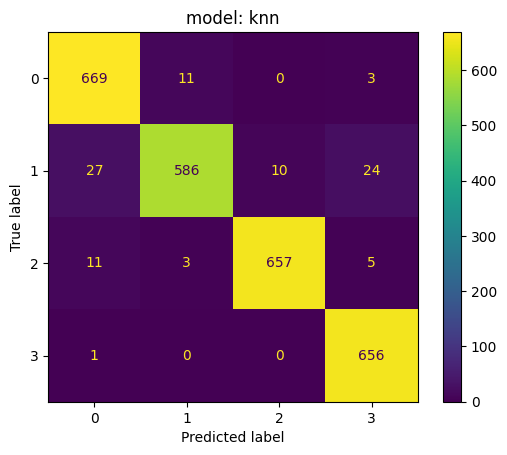

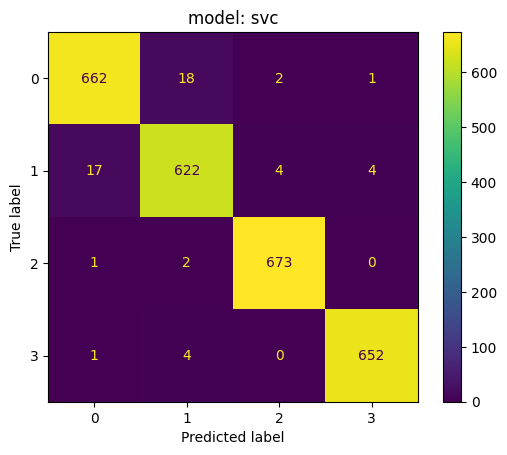

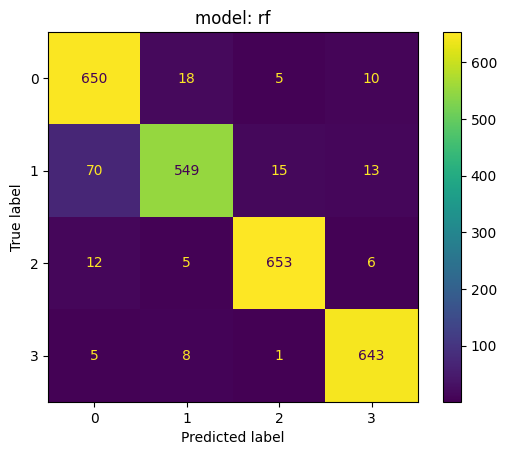

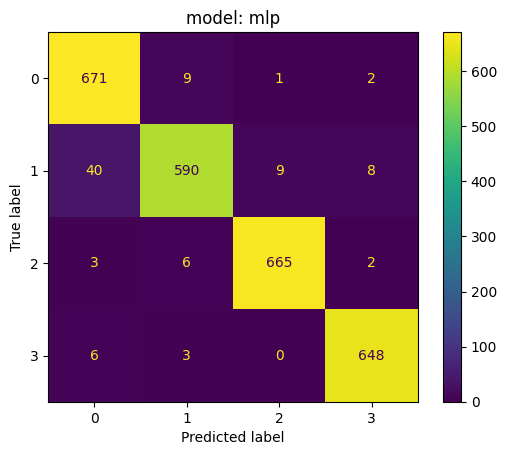

In [ ]:
ml_cm = {}
for (name, y_pred) in preds.items():
  cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
  ml_cm[name] = cm
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=clf.classes_)
  disp.plot()
  plt.title(f"model: {name}")
  plt.show()

In [ ]:
for (name, cmat) in ml_cm.items():
  print(name)
  evaluation(cmat)
  print("========================================")

knn
Class 0: Sensitivity = 0.98, Specificity = 0.98, Accuracy = 0.93
Class 1: Sensitivity = 0.91, Specificity = 0.99, Accuracy = 0.89
Class 2: Sensitivity = 0.97, Specificity = 0.99, Accuracy = 0.96
Class 3: Sensitivity = 1.00, Specificity = 0.98, Accuracy = 0.95

Average Sensitivity: 0.96
Average Specificity: 0.99
Average Accuracy: 0.93
svc
Class 0: Sensitivity = 0.97, Specificity = 0.99, Accuracy = 0.94
Class 1: Sensitivity = 0.96, Specificity = 0.99, Accuracy = 0.93
Class 2: Sensitivity = 1.00, Specificity = 1.00, Accuracy = 0.99
Class 3: Sensitivity = 0.99, Specificity = 1.00, Accuracy = 0.98

Average Sensitivity: 0.98
Average Specificity: 0.99
Average Accuracy: 0.96
rf
Class 0: Sensitivity = 0.95, Specificity = 0.96, Accuracy = 0.84
Class 1: Sensitivity = 0.85, Specificity = 0.98, Accuracy = 0.81
Class 2: Sensitivity = 0.97, Specificity = 0.99, Accuracy = 0.94
Class 3: Sensitivity = 0.98, Specificity = 0.99, Accuracy = 0.94

Average Sensitivity: 0.94
Average Specificity: 0.98
Aver

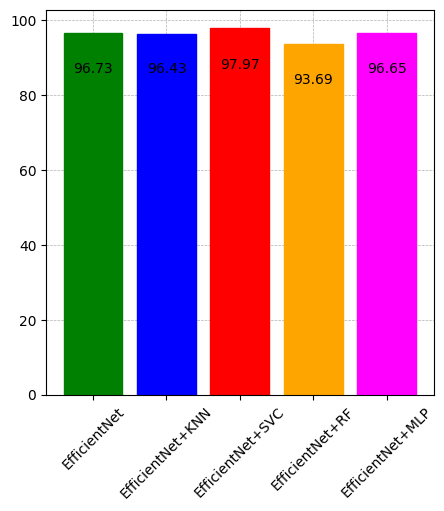

In [ ]:
acc = {
    'EfficientNet': 96.73,
    'EfficientNet+KNN': 96.43,
    'EfficientNet+SVC': 97.97,
    'EfficientNet+RF': 93.69,
    'EfficientNet+MLP': 96.65
}

names = list(acc.keys())
values = list(acc.values())

plt.figure(figsize=(5, 5))
plt.xticks(rotation=45)
bars=plt.bar(range(len(acc)), values, tick_label=[n for (i, n) in enumerate(names)], zorder=2)

bars[0].set_color('green')
bars[1].set_color('blue')
bars[2].set_color('red')
bars[3].set_color('orange')
bars[4].set_color('magenta')


def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//1 - 10, y[i], ha = 'center', rotation='horizontal')

addlabels(names, values)

plt.grid(linestyle = '--', linewidth = 0.5, zorder=1)
plt.show()

***Specificity & Sensitivity***

In [ ]:
def calculate_sensitivity(tp, fn):
    """Calculate sensitivity (recall)"""
    return tp / (tp + fn) if (tp + fn) > 0 else 0

def calculate_specificity(tn, fp):
    """Calculate specificity"""
    return tn / (tn + fp) if (tn + fp) > 0 else 0

def calculate_accuracy(tp, fp, fn):
    """Calculate accuracy"""
    return  tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0

def evaluation(confusion_matrix):

    num_classes = confusion_matrix.shape[0]
    sensitivities = []
    specificities = []
    accuracies = []

    for i in range(num_classes):
        tp = confusion_matrix[i, i]
        fn = np.sum(confusion_matrix[i, :]) - tp
        fp = np.sum(confusion_matrix[:, i]) - tp
        tn = np.sum(confusion_matrix) - (tp + fp + fn)

        sensitivity = calculate_sensitivity(tp, fn)
        specificity = calculate_specificity(tn, fp)
        accuracy = calculate_accuracy(tp, fp, fn)

        sensitivities.append(sensitivity)
        specificities.append(specificity)
        accuracies.append(accuracy)

        print(f"Class {i}: Sensitivity = {sensitivity:.2f}, Specificity = {specificity:.2f}, Accuracy = {accuracy:.2f}")

    # Average Sensitivity and Specificity
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)
    avg_accuracy = np.mean(accuracies)

    print(f"\nAverage Sensitivity: {avg_sensitivity:.2f}")
    print(f"Average Specificity: {avg_specificity:.2f}")
    print(f"Average Accuracy: {avg_accuracy:.2f}")

# Results

EfficientNet:

Average Sensitivity: 0.98,
Average Specificity: 0.99,
Average Accuracy: 0.95,
__________________________________________________________
EfficientNet+KNN:

Average Sensitivity: 0.96,
Average Specificity: 0.99,
Average Accuracy: 0.93,
__________________________________________________________
EfficientNet+SVC:

Average Sensitivity: 0.98,
Average Specificity: 0.99,
Average Accuracy: 0.96,
__________________________________________________________
EfficientNet+RF:

Average Sensitivity: 0.94,
Average Specificity: 0.98,
Average Accuracy: 0.88,
__________________________________________________________
EfficientNet+MLP:

Average Sensitivity: 0.97,
Average Specificity: 0.99,
Average Accuracy: 0.94,

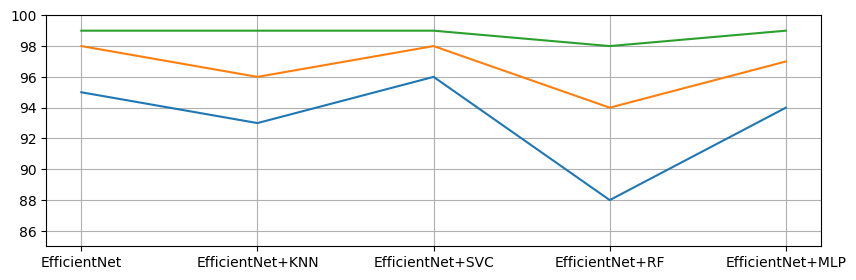

In [ ]:
name_list = ['EfficientNet', 'EfficientNet+KNN', 'EfficientNet+SVC',
             'EfficientNet+RF', 'EfficientNet+MLP']
acc_list = [95, 93, 96, 88, 94]
sen_list = [98, 96, 98, 94, 97]
spe_list = [99, 99, 99, 98, 99]

plt.figure(figsize=(10, 3))

plt.plot(name_list, acc_list)
plt.plot(name_list, sen_list)
plt.plot(name_list, spe_list)
plt.ylim(85, 100)
plt.grid()

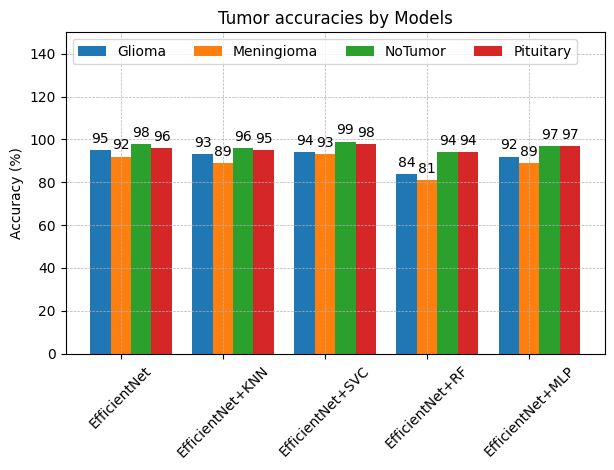

In [ ]:
modelnames = (
    'EfficientNet',
    'EfficientNet+KNN',
    'EfficientNet+SVC',
    'EfficientNet+RF',
    'EfficientNet+MLP'
)

tumor_acc = {
    'Glioma':     (0.95, 0.93, 0.94, 0.84, 0.92),
    'Meningioma': (0.92, 0.89, 0.93, 0.81, 0.89),
    'NoTumor':    (0.98, 0.96, 0.99, 0.94, 0.97),
    'Pituitary':  (0.96, 0.95, 0.98, 0.94, 0.97),
}

x = np.arange(len(modelnames))
width = 0.2
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in tumor_acc.items():
    offset = width * multiplier
    measurement = [m*100 for m in measurement]
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Accuracy (%)')
ax.set_title('Tumor accuracies by Models')
ax.set_xticks(x + width, modelnames)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 150)

plt.grid(linestyle = '--', linewidth = 0.5, zorder=1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()